In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import sin, cos, sqrt, atan2, radians, ceil
import folium
from folium import Map
from folium.plugins import HeatMapWithTime
import warnings
warnings.filterwarnings("ignore")

In [2]:
OUTPUT_ROOT = "/path/to/output"
GPS_PATH = f"{OUTPUT_ROOT}/gps_data"
METADATA_PATH = f"{OUTPUT_ROOT}/metadata"
NETWORK_PATH = f"{OUTPUT_ROOT}/network_data"
PROFILE_NAME = "tartu_user_employed_walk"
MEAN_VELOCITY_MS = 1.1

In [3]:
clean_profile_name = ' '.join(PROFILE_NAME.split('_'))

In [4]:
gps_all = pd.read_parquet(GPS_PATH, engine="pyarrow")
metadata_all = pd.read_parquet(METADATA_PATH, engine="pyarrow")
network_all = pd.read_parquet(NETWORK_PATH, engine="pyarrow")

In [5]:
# glimpse of data
display(gps_all.head())
display(metadata_all.head())
display(network_all.head())

,user_id,timestamp,lon,lat,profile_name
0,1,2022-07-22 00:01:00,26.703284,58.359932,tartu_user_employed_walk
1,1,2022-07-22 00:04:00,26.703265,58.359975,tartu_user_employed_walk
2,1,2022-07-22 00:07:00,26.703274,58.359924,tartu_user_employed_walk
3,1,2022-07-22 00:11:00,26.703293,58.359967,tartu_user_employed_walk
4,1,2022-07-22 00:12:00,26.703270,58.359937,tartu_user_employed_walk


,user_id,home_id,work_id,regular_loc_array,network_name,profile_name
0,1,30222259,30224589,"[651553648, 3684690480, 2406321446, 7879083254]",tartu_walk,tartu_user_employed_walk
1,2,227824423,228911987,"[30238570, 448614341, 96241844, 4018232918]",tartu_walk,tartu_user_employed_walk
2,1,742771090,30224866,"[8107349406, 357843701, 6555277319, 423609797,...",tartu_walk,tartu_user_employed_walk_2
3,2,228405284,30241083,"[275474319, 7838166517, 7879083193, 1005135332...",tartu_walk,tartu_user_employed_walk_2
4,3,30229443,228911803,"[655255193, 11224873450, 1117230039, 2442695959]",tartu_walk,tartu_user_employed_walk_2


,element_type,osmid,centre_y,name,centre_x,loc_type,network_name
0,node,2345996395,58.373195,TÜ Geograafia osakond,26.715520,hw,tartu_walk
1,way,30190910,58.351225,None,26.683441,hw,tartu_walk
2,way,30221534,58.389387,None,26.735223,hw,tartu_walk
3,way,30221538,58.346422,None,26.717757,hw,tartu_walk
4,way,30221540,58.365181,None,26.699989,hw,tartu_walk


In [6]:
gps_profile = gps_all[gps_all['profile_name']==PROFILE_NAME].reset_index(drop=True)
metadata_profile = metadata_all[metadata_all['profile_name']==PROFILE_NAME].reset_index(drop=True)

In [7]:
random_user_id = random.randint(1, gps_profile['user_id'].nunique())
network_name = metadata_profile['network_name'].unique()[0]
network_profile = network_all[network_all['network_name']==network_name].reset_index(drop=True)
gps_random_user = gps_profile[gps_profile['user_id']==random_user_id].reset_index(drop=True)

In [8]:
gps_random_user['date'] = gps_random_user['timestamp'].dt.date.astype(str) + " (" + gps_random_user['timestamp'].dt.day_name().astype(str) + ")"

In [9]:
grouped_data = gps_random_user.groupby('date')
lat_long_list = [groups[['lat', 'lon']].values.tolist() for key, groups in grouped_data]
date_strings = list(gps_random_user['date'].unique())

In [10]:
# add anchors
metadata_user = metadata_profile[metadata_profile['user_id']==random_user_id]
home_anchor = network_profile[network_profile['osmid']==metadata_user['home_id'].values[0]][['centre_y', 'centre_x']].values.tolist()[0]
work_anchor = network_profile[network_profile['osmid']==metadata_user['work_id'].values[0]][['centre_y', 'centre_x']].values.tolist()[0]
regular_event_anchors = network_profile[network_profile['osmid'].isin(metadata_user['regular_loc_array'].values[0])][['centre_y', 'centre_x']].values.tolist()

In [11]:
event_icons = ['picture-o', 'glass', 'shopping-cart', 'info', 'group', 'coffee']

In [12]:
city_lat = 58.378025
city_lon = 26.728493
m=Map(width=1250, 
      height=500,
      location=[city_lat, city_lon], 
      zoom_start=12, 
      min_zoom=3,
      max_bounds=True)

folium.Marker(
  location=home_anchor,
  popup='home', 
  icon=folium.Icon(color='lightgray', icon='home', prefix='fa')
).add_to(m)

folium.Marker(
  location=work_anchor,
  popup='work', 
  icon=folium.Icon(color='darkblue', icon='briefcase', prefix='fa')
).add_to(m)
for regular_event_anchor in regular_event_anchors:
    folium.Marker(
      location= regular_event_anchor,
      popup='regular event',
      icon=folium.Icon(icon=random.choice(event_icons), prefix='fa')
    ).add_to(m)

In [13]:
title_html = f'''
             <h3 align="center" style="font-size:15px"><b>GPS data visualisation for one user\
             ({clean_profile_name})</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))  
HeatMapWithTime(lat_long_list, radius=10, auto_play=True, index=date_strings, max_opacity=0.5, min_speed=2).add_to(m)
m.save(f'{OUTPUT_ROOT}/gps_visualisation_map.html')
m

In [14]:
def distance_in_km(lat1,lon1,lat2,lon2):
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)
    dLon = radians(lon2-lon1)
    rLat1 = radians(lat1)
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c # Distance in km
    return d

In [15]:
def speed(dist_km, time_start, time_end):
    return round(dist_km / ((time_end - time_start).total_seconds()/3600), 1) if time_end > time_start else 0

In [16]:
def get_distance_and_speed(lat1, lon1, lat2, lon2, time_start, time_end): 
    dist_km = distance_in_km(lat1,lon1,lat2,lon2)
    velocity_kmh = speed(dist_km, time_start, time_end)
    
    return velocity_kmh

In [17]:
def df_with_speed(df, user_column, lon_column, lat_column, timestamp_column): 
    
    df['lon_end'] = df[lon_column].shift(-1)
    df['lat_end'] = df[lat_column].shift(-1)
    df['timestamp_end']= df[timestamp_column].shift(-1)
    df_with_speed=pd.DataFrame()
    for i in df[user_column].unique():
        df_transitional=pd.DataFrame()
        df_transitional=df[df[user_column]==i]
        df_with_speed=pd.concat([df_with_speed, df_transitional])
        df_with_speed.drop(index=df_with_speed.index[-1],axis=0,inplace=True)
        
    df_with_speed['speed_kmh'] = df_with_speed.apply(
        lambda row: get_distance_and_speed(
        lat1=row[lat_column],
        lon1=row[lon_column],
        lat2=row['lat_end'],
        lon2=row['lon_end'], 
        time_start=row[timestamp_column], 
        time_end=row['timestamp_end']
    ),
    axis=1)
    
    df_with_speed.drop(columns = ['lat_end', 'lon_end', 'timestamp_end'], inplace = True)
    
    return df_with_speed

In [18]:
gps_profile_with_speed = df_with_speed(gps_profile, 'user_id', 'lon', 'lat', 'timestamp')

In [19]:
display(gps_profile_with_speed.head())

,user_id,timestamp,lon,lat,profile_name,speed_kmh
0,1,2022-07-22 00:01:00,26.703284,58.359932,tartu_user_employed_walk,0.1
1,1,2022-07-22 00:04:00,26.703265,58.359975,tartu_user_employed_walk,0.1
2,1,2022-07-22 00:07:00,26.703274,58.359924,tartu_user_employed_walk,0.1
3,1,2022-07-22 00:11:00,26.703293,58.359967,tartu_user_employed_walk,0.2
4,1,2022-07-22 00:12:00,26.703270,58.359937,tartu_user_employed_walk,0.0


In [20]:
def ms_to_kmh(speed_ms):
    return speed_ms * 3.6

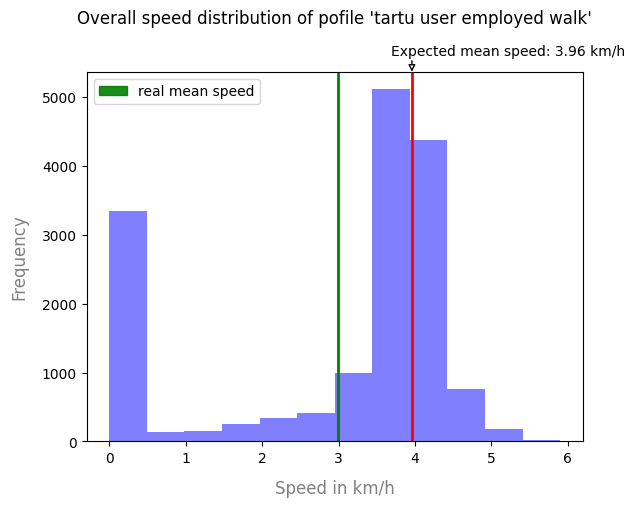

In [21]:
x_fraction=0.5
num_bins = ceil(gps_profile_with_speed['speed_kmh'].max()/x_fraction)
fig, ax = plt.subplots()
ax.hist(gps_profile_with_speed['speed_kmh'], bins=num_bins, color='blue', alpha=0.5)

expected_mean_speed_kmh = round(ms_to_kmh(MEAN_VELOCITY_MS),2)
real_mean_speed_kmh = round(gps_profile_with_speed['speed_kmh'].mean(), 2)
ax.axvline(expected_mean_speed_kmh, color='red', linewidth=2)
ax.axvline(real_mean_speed_kmh, color='green', linewidth=2)

ax.annotate(f'Expected mean speed: {expected_mean_speed_kmh} km/h', 
            xy=(expected_mean_speed_kmh, 1), 
            xytext=(-15, 15),
            xycoords=('data', 'axes fraction'), textcoords='offset points',
            horizontalalignment='left', verticalalignment='center',
            arrowprops=dict(arrowstyle='-|>', fc='white', shrinkA=0, shrinkB=0,       
                        connectionstyle='angle,angleA=0,angleB=90,rad=10'),)

ax.set_title(f"Overall speed distribution of pofile '{clean_profile_name}'",
            loc='center', 
            pad=35)
ax.set_xlabel("Speed in km/h", labelpad=10.0, color='grey', fontsize='large')
ax.set_ylabel("Frequency", labelpad=10.0, color='grey', fontsize='large')
green_patch = mpatches.Patch(color='green', alpha=0.9, label='real mean speed')
ax.legend(handles=[green_patch], loc='upper left')
plt.savefig(f'{OUTPUT_ROOT}/speed_distribution.png', bbox_inches='tight')
plt.show()